In [1]:
!pip install matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ----------- ---------------------------- 2.4/8.1 MB 11.8 MB/s eta 0:00:01
   ----------------------- ---------------- 4.7/8.1 MB 11.8 MB/s eta 0:00:01
   ---------------------------------- ----- 7.1/8.1 MB 11.8 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 11.2 MB/s  0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ------------------------------- -------- 1.8/2.3 MB 8.9 MB/s eta 0:00:01
   ---------------------------------------- 2.3/2.3 MB 8.7 MB/s  0:00:00
   ---------------------------------------- 0.0/7.0 MB ? eta -:--:--
   ------------- -------------------------- 2.4/7.0 MB 11.9 MB/s eta 0:00:01
   -------------------------- ------------- 4.7/7.0 MB 11.9 MB/s eta 0:00:01
   -------------------------------------- - 6.8/7.0 MB 11.8 MB/s eta

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
from tqdm import tqdm
from functions import *

plt.style.use("fivethirtyeight")
plt.style.use("seaborn-v0_8")
plt.rcParams["font.family"] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

In [3]:
pd.set_option('mode.chained_assignment',  None)

In [4]:
# 분석할 팩터 선정  ('pbr','pcr','por','psr','per','roe') 중 아무거나 선택해서 factor 변수에 대입시켜서 실험을 통하여 다양한 결과들을 얻을 수 있다.
factors = ['per', 'pbr']

In [5]:
year_start, year_end= 2012, 2022

In [ ]:
df_factors_ = pd.read_csv("./data/factors.csv")
df_factors_.columns = ['date', 'year', 'ticker', 'pbr', 'per', 'yield', 'seq', 'tradingvolume', 'ind']
df_factors = df_factors_[(df_factors_['year']>=year_start) & (df_factors_['year']<year_end)]
df_factors = df_factors.dropna(subset=factors)
df_factors.replace(np.inf, 3e14, inplace=True)
df_factors = df_factors[(df_factors['seq'] > df_factors['seq'].quantile(0.01)) & (df_factors['yield']<40) &(df_factors['yield']>0.025)& (df_factors['tradingvolume']!=0)]
df_factors.reset_index(drop=True,inplace=True)

In [ ]:
med = {}
for factor in factors:
    df_factors_t = df_factors[df_factors[factor]>0]
    med[factor] = round(df_factors_t[factor].median(), 1)
med

{'per': np.float64(77.0), 'pbr': np.float64(4.1)}

In [ ]:
def factor_yield_med(factor, year, factor_over_med, factor_under_med, amean_over_med, amean_under_med):
    amean_over_med[factor][year]['arr'].append(factor_over_med['yield'].mean())
    amean_under_med[factor][year]['arr'].append(factor_under_med['yield'].mean())

In [21]:
def factor_ratio_med(factor, factor_over_med, factor_under_med, factor_under_total, factor_under_ratio, factor_over_total, factor_over_ratio):
    factor_under_up = factor_under_med[factor_under_med['yield']>1]
    factor_under_down = factor_under_med[factor_under_med['yield']<=1]
    factor_under_up10 = factor_under_med[factor_under_med['yield']>1.1]
    factor_under_down10 = factor_under_med[factor_under_med['yield']<=0.909]
    factor_under_up20 = factor_under_med[factor_under_med['yield']>1.2]
    factor_under_down20 = factor_under_med[factor_under_med['yield']<=0.837]

    factor_over_up = factor_over_med[factor_over_med['yield']>1]
    factor_over_down = factor_over_med[factor_over_med['yield']<=1]
    factor_over_up10 = factor_over_med[factor_over_med['yield']>1.1]
    factor_over_down10 = factor_over_med[factor_over_med['yield']<=0.909]
    factor_over_up20 = factor_over_med[factor_over_med['yield']>1.2]
    factor_over_down20 = factor_over_med[factor_over_med['yield']<=0.837]

    factor_under_total[factor] += factor_under_med.shape[0]
    factor_over_total[factor] += factor_over_med.shape[0]

    factor_under_ratio[factor][0]+=factor_under_down20.shape[0]
    factor_under_ratio[factor][1]+=factor_under_down10.shape[0]
    factor_under_ratio[factor][2]+=factor_under_down.shape[0]
    factor_under_ratio[factor][3]+=0
    factor_under_ratio[factor][4]+=factor_under_up.shape[0]
    factor_under_ratio[factor][5]+=factor_under_up10.shape[0]
    factor_under_ratio[factor][6]+=factor_under_up20.shape[0]
    
    factor_over_ratio[factor][0]+=factor_over_down20.shape[0]
    factor_over_ratio[factor][1]+=factor_over_down10.shape[0]
    factor_over_ratio[factor][2]+=factor_over_down.shape[0]
    factor_over_ratio[factor][3]+=0
    factor_over_ratio[factor][4]+=factor_over_up.shape[0]
    factor_over_ratio[factor][5]+=factor_over_up10.shape[0]
    factor_over_ratio[factor][6]+=factor_over_up20.shape[0]

In [22]:
def factor_yield_extreme(data, factor, year, date_med, factor_over_med, factor_under_med, samples_yield):
    dfs = []
    dfs.append(data[data[factor]<date_med/5])
    dfs.append(factor_under_med)
    dfs.append(factor_over_med)
    dfs.append(data[data[factor]>date_med*5])

    for i, df in enumerate(dfs):
        samples_yield[i][factor][year]['arr'].append(df['yield'].mean())

In [ ]:
# 수익률 중앙값을 중심으로 한 factor 1년간 수익률
amean_over_med = {}
amean_under_med = {}

# 수익률 중앙값을 중심으로 한 factor 상승, 하강 비율
factor_under_total = {}
factor_over_total = {}
factor_under_ratio = {}
factor_over_ratio = {}

# 극단값 수익률
samples_yield = [{},{},{},{}]

for factor in factors:
    amean_over_med[factor] = {}
    amean_under_med[factor] = {}

    factor_under_total[factor] = 0
    factor_over_total[factor] = 0
    factor_under_ratio[factor] = np.array([0]*7)
    factor_over_ratio[factor] = np.array([0]*7)

    for i in range(4):
        samples_yield[i][factor] = {}


for year in range(year_start, year_end):
    cur_date = datetime.datetime.strptime(str(year)+"-01-01" ,"%Y-%m-%d")
    for factor in factors:
        amean_over_med[factor][year] = {'arr': []}
        amean_under_med[factor][year] = {'arr': []}

        for i in range(4):
            samples_yield[i][factor][year] = {'arr': []}


    for i in tqdm(range(370)):
        if cur_date.year != year:
            break
        data = df_factors[df_factors['date'] == cur_date.strftime("%Y-%m-%d")]
        if len(data) ==0:
            cur_date +=datetime.timedelta(30)
            continue


        for factor in factors:
            date_med = med[factor]
            data = data[data[factor]>0]
            factor_under_med = data[data[factor] < date_med]
            factor_over_med = data[data[factor] > date_med]
            factor_yield_med(factor, year, factor_over_med, factor_under_med, amean_over_med, amean_under_med)
            factor_ratio_med(factor, factor_over_med, factor_under_med, factor_under_total, factor_under_ratio, factor_over_total, factor_over_ratio)
            factor_yield_extreme(data, factor, year, date_med, factor_over_med, factor_under_med, samples_yield)
        cur_date +=datetime.timedelta(30)
        


 99%|█████████▊| 365/370 [00:03<00:00, 97.87it/s]


In [24]:
amean_over_med_year_mean = {}
amean_under_med_year_mean = {}

for factor in factors:
    amean_over_med_year_mean[factor] = []
    amean_under_med_year_mean[factor] = []
    
for year in range(year_start,year_end):
    for factor in factors:
        amean_over_med_year_mean[factor].append(sum(amean_over_med[factor][year]['arr'])/len(amean_over_med[factor][year]['arr'])* 100 - 100)
        amean_under_med_year_mean[factor].append(sum(amean_under_med[factor][year]['arr'])/len(amean_under_med[factor][year]['arr'])* 100 - 100)


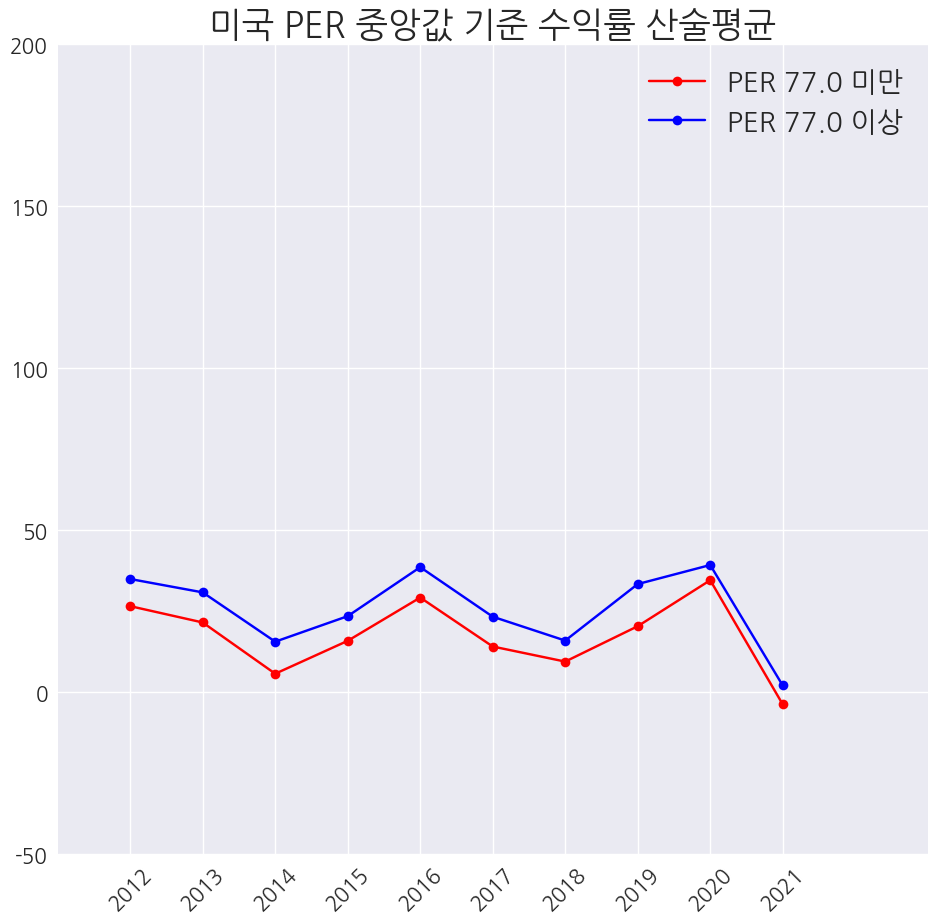

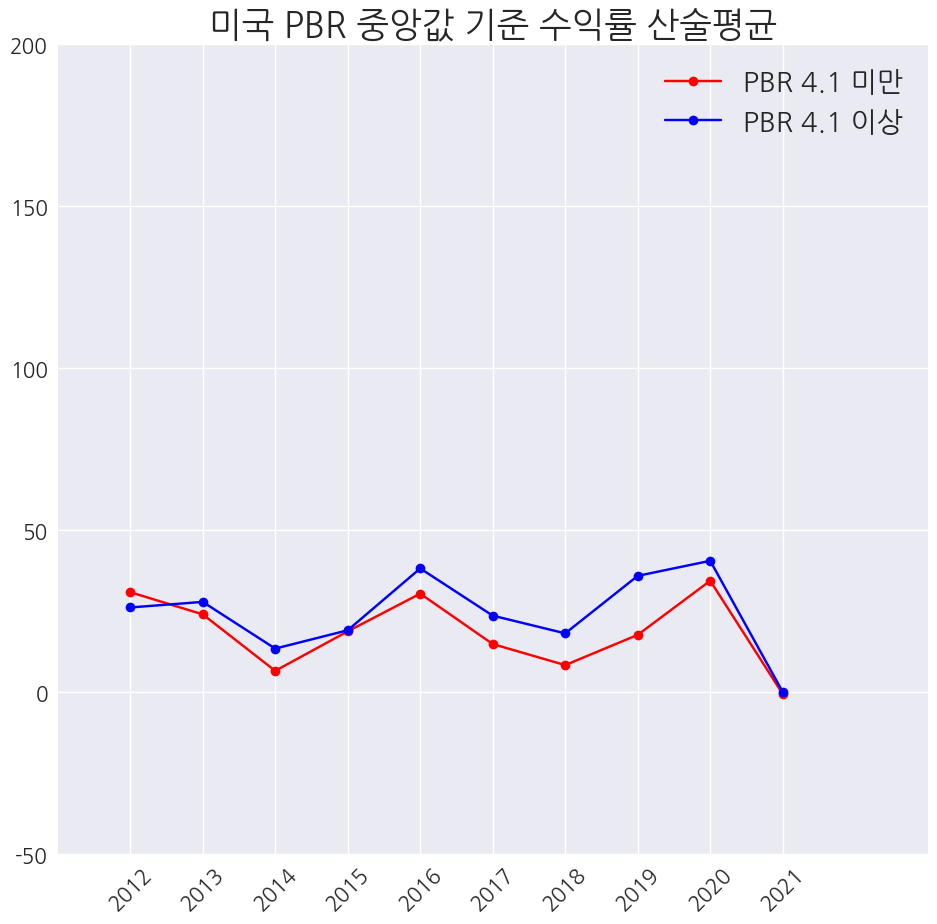

In [25]:
#pbr 해당년도까지의 pbr median 을 기준으로 plot ""
# 산술 평균
plt.rcParams["font.family"] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

for factor in factors:
    years = range(year_start,year_end)
    plt.figure(figsize=(10,10))
    plt.title(f"미국 {factor.upper()} 중앙값 기준 수익률 산술평균",fontsize=25)
    plt.xticks(np.arange(year_start,year_end))
    plt.xticks(fontsize = 15, rotation=45)
    plt.yticks(fontsize= 15)
    plt.plot(years,amean_under_med_year_mean[factor],marker='o',label=f'{factor.upper()} {med[factor]} 미만',color='r')
    plt.plot(years,amean_over_med_year_mean[factor],marker='o',label=f'{factor.upper()} {med[factor]} 이상',color='b')

    plt.legend(loc='best',fontsize=20)
    plt.xlim(year_start-1,year_end+1)
    plt.ylim(-50,200)
    plt.show()


In [26]:
for factor in factors:
    factor_under_ratio[factor] = factor_under_ratio[factor]/factor_under_total[factor]
    factor_over_ratio[factor] = factor_over_ratio[factor]/factor_over_total[factor]

    for i in range(len(factor_under_ratio[factor])):
        factor_under_ratio[factor][i]*=100
        factor_over_ratio[factor][i]*=100

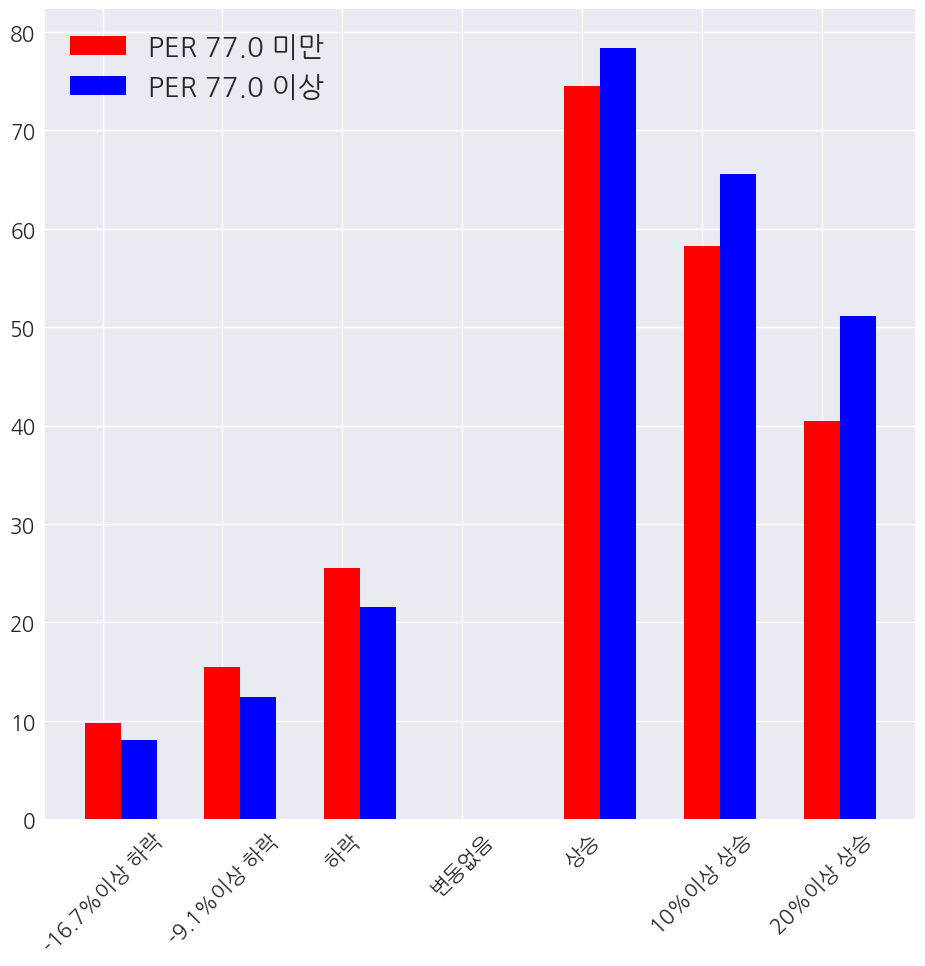

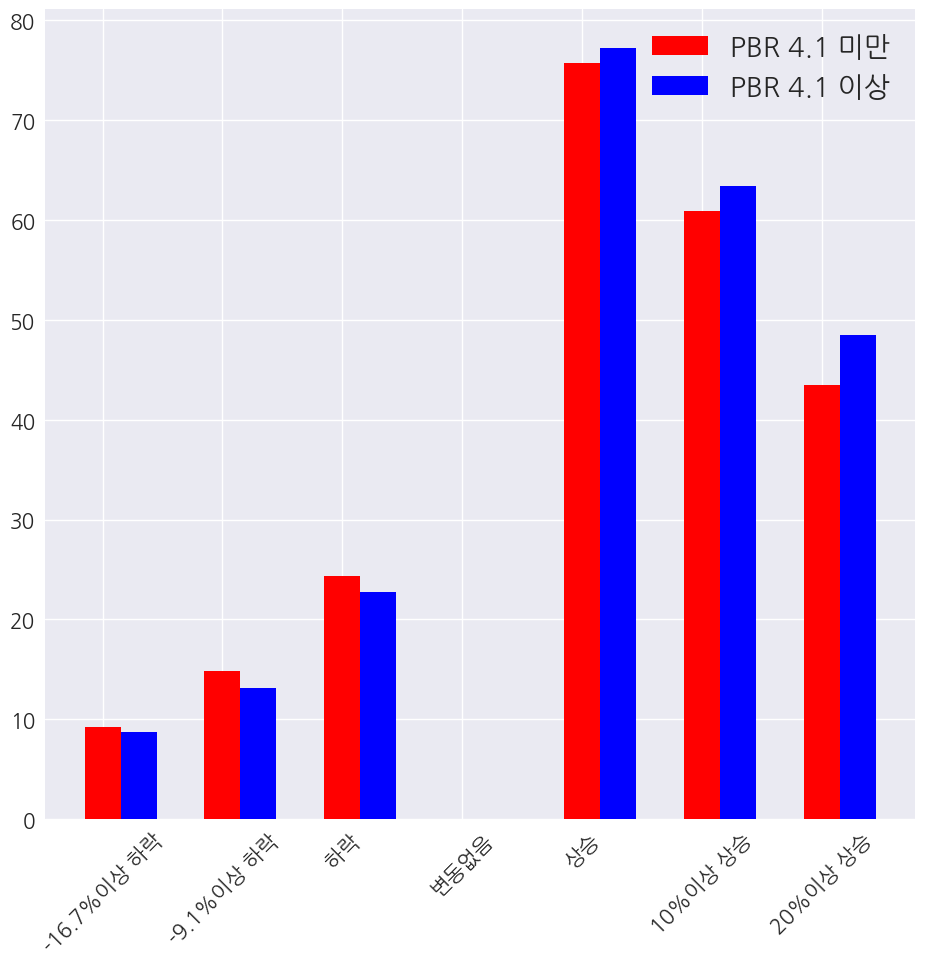

In [27]:
label = ['-16.7%이상 하락','-9.1%이상 하락','하락','변동없음','상승','10%이상 상승','20%이상 상승']
x = np.arange(len(label))
for factor in factors:
    plt.figure(figsize=(10,10))
    plt.bar(x,factor_under_ratio[factor],label=f'{factor.upper()} {med[factor]} 미만',width=0.3,color='r')
    plt.bar(x+0.3,factor_over_ratio[factor],label=f'{factor.upper()} {med[factor]} 이상',width=0.3,color='b')
    plt.xticks(x,label,size=12)
    plt.xticks(rotation=45,fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend(loc='best',fontsize=20)

In [28]:
samples_yield_mean = {}
for factor in factors:
    samples_yield_mean[factor] = [[],[],[],[]]

for factor in factors:
    for year in range(year_start,year_end):
        for i, sample_yield in enumerate(samples_yield):
            samples_yield_mean[factor][i].append(sum(sample_yield[factor][year]['arr'])/len(sample_yield[factor][year]['arr'])* 100 - 100)

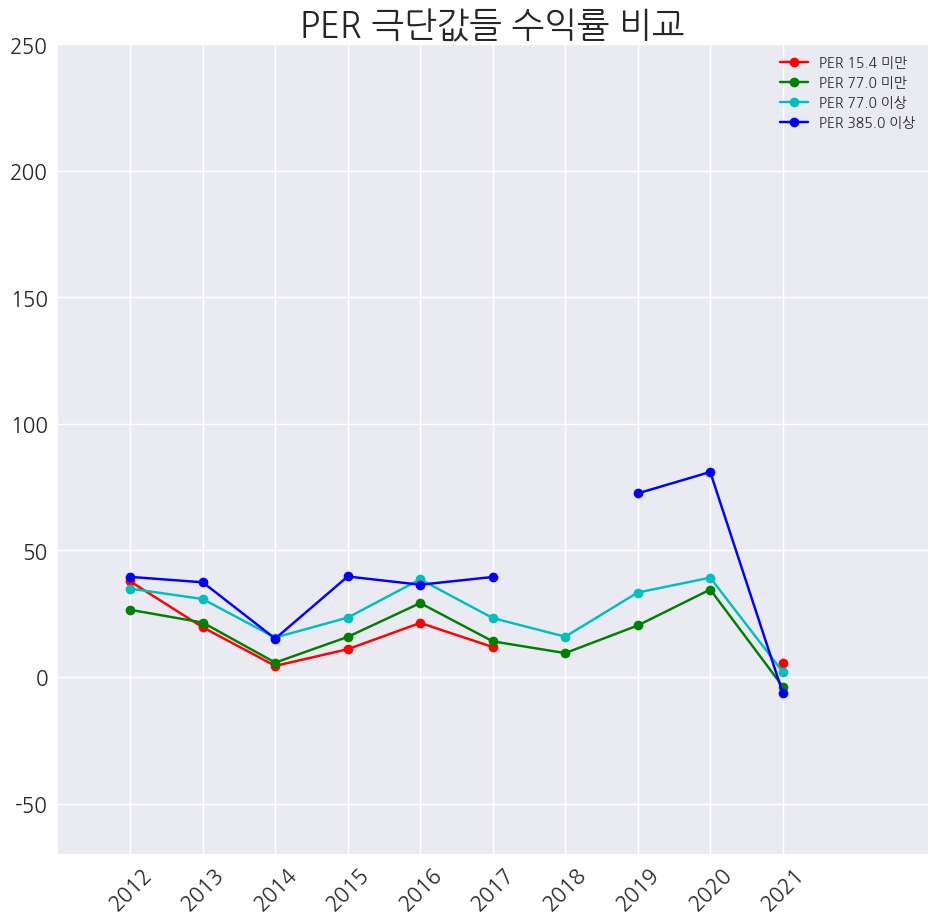

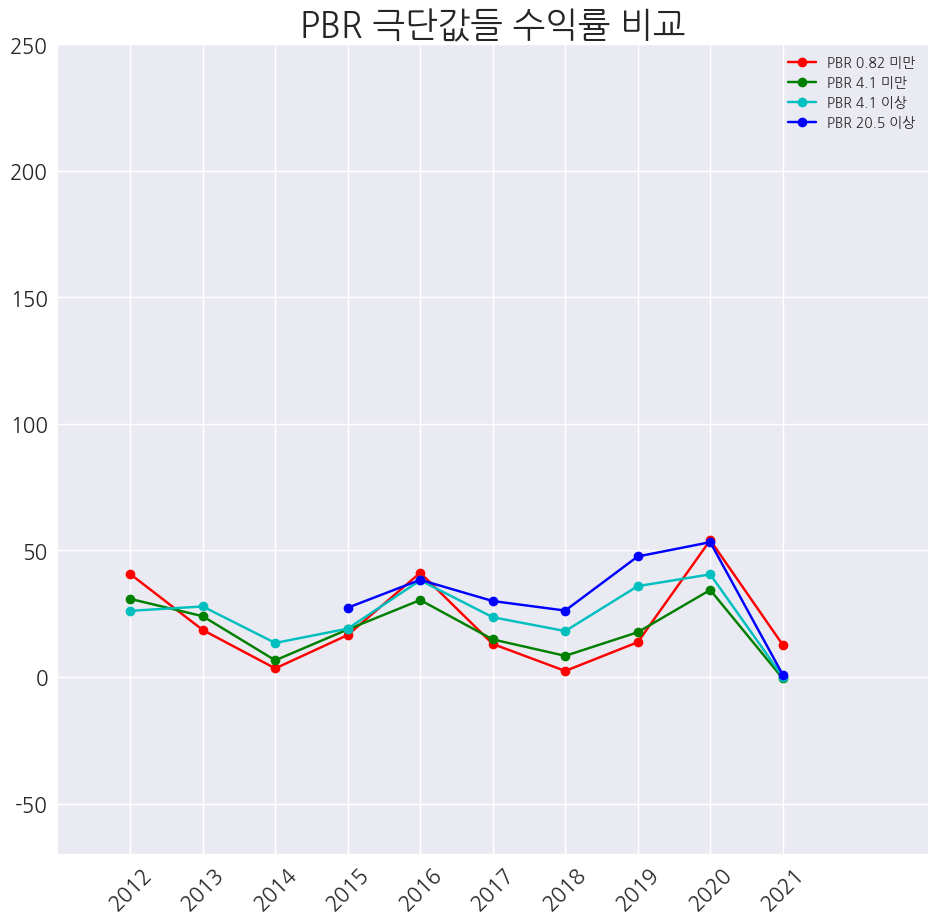

In [35]:
#pbr 해당년도까지의 pbr median 을 기준으로 plot 
# 산술 평균
years = range(year_start, year_end)
for factor in factors:
    plt.figure(figsize=(10,10))
    plt.title(f"{factor.upper()} 극단값들 수익률 비교",fontsize=25)
    plt.xticks(np.arange(year_start, year_end))
    plt.xticks(rotation=45,fontsize=15)
    plt.yticks(fontsize=15)
    plt.plot(years,samples_yield_mean[factor][0],marker='o',label=f'{factor.upper()} {med[factor]/5} 미만',color='r')
    plt.plot(years,samples_yield_mean[factor][1],marker='o',label=f'{factor.upper()} {med[factor]} 미만',color='g')
    plt.plot(years,samples_yield_mean[factor][2],marker='o',label=f'{factor.upper()} {med[factor]} 이상',color='c')
    plt.plot(years,samples_yield_mean[factor][3],marker='o',label=f'{factor.upper()} {med[factor]*5} 이상',color='b')
    plt.legend(loc='best',fontsize=10)
    plt.xlim(year_start-1,year_end+1)
    plt.ylim(-70,250)
    plt.show()


In [36]:
def ten_group_amean(df, year, amean):
    for factor in factors:
        df_sorted= df.sort_values(by=[factor],axis=0)
        for i, q in enumerate(np.arange(0,1,0.1)):
            start = q
            end=q+0.1
            start_factor = df_sorted[factor].quantile(q=start)
            end_factor = df_sorted[factor].quantile(q=end)
            yield_q = df_sorted[(df_sorted[factor]>start_factor) & (df_sorted[factor] <= end_factor)]
            amean[i][year][factor].append(yield_q['yield'].mean())

In [37]:
def ten_group_plot(amean):
    for factor in factors:
        L = max([len(amean[0][year][factor]) for year in range(year_start, year_end)])
        gmean_q = np.array([float(0)]*10)
        for date_ind in range(L):
            gmean_q_date = []
            for i in range(10):
                amean_date = []
                for year in range(year_start, year_end):
                    if date_ind >= len(amean[i][year][factor]):
                        date_ind -=1
                    amean_date.append(amean[i][year][factor][date_ind])
                gmean_q_date.append(multiply_overflow(amean_date))
            gmean_q += np.array(gmean_q_date)
        gmean_q = gmean_q / L

        gmean_q = np.exp(np.log(gmean_q)/(year_end-year_start))
        gmean_q= np.array(gmean_q) * 100 - 100
        # plot
        print(gmean_q)
        num = np.arange(1,11)
        plt.title(f"{factor.upper()} 십분위 연평균 수익률 비교",fontsize=20)
        plt.bar(num,gmean_q)
        plt.ylabel("yield")
        plt.xlabel(factor)
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
        plt.ylim(-5,30)
        plt.xticks(num,num)
        plt.show()

In [38]:
def gmean_total(amean):
    L = max([len(amean[year]) for year in range(year_start, year_end)])
    gmean_q = 0
    for date_ind in range(L):
        amean_date = []
        for year in range(year_start, year_end):
            if date_ind >= len(amean[year]):
                date_ind -=1
            amean_date.append(amean[year][date_ind])
        gmean_q += multiply_overflow(amean_date)
    gmean_q = gmean_q / L
    gmean_q = np.exp(np.log(gmean_q)/(year_end-year_start))
    gmean_q= np.array(gmean_q) * 100 - 100
    # plot
    print(gmean_q)

In [39]:
amean = []
amean_refined = []
amean_refined_harsh = []
amean_total = {}

for i in range(10):
    amean.append({})
    amean_refined.append({})
    amean_refined_harsh.append({})

for year in range(year_start, year_end):
    for i in range(10):
        amean[i][year] = {}
        amean_refined[i][year] = {}
        amean_refined_harsh[i][year] = {}
        amean_total[year] = []
        for factor in factors:
            amean[i][year][factor] = []
            amean_refined[i][year][factor] = []
            amean_refined_harsh[i][year][factor] = []
        
    cur_date = datetime.datetime.strptime(str(year)+"-01-01" ,"%Y-%m-%d")
    for i in tqdm(range(370)):
        if cur_date.year != year:
            break
        
        data = df_factors[df_factors['date'] == cur_date.strftime("%Y-%m-%d")]
        if len(data) ==0:
            cur_date +=datetime.timedelta(30)
            continue

        data = data[data[factor]>0]

        # 자본 총계 하위 1프로 제거
        data_refined_ease = data.copy()
        data_refined_ease.reset_index(drop=True,inplace=True)
        ten_group_amean(data_refined_ease, year, amean)

        # 자본 총계 하위 5프로 제거 
        data_refined = data[(data['seq'] > data['seq'].quantile(0.05))]
        data_refined.reset_index(drop=True,inplace=True)
        ten_group_amean(data_refined, year, amean_refined)

        # 자산 총계 하위 50 거래량 30 프로 제거 
        data_refined_harsh = data[(data['seq'] > data['seq'].quantile(0.5)) & (data['tradingvolume']>data['tradingvolume'].quantile(0.3))]
        data_refined.reset_index(drop=True,inplace=True)
        ten_group_amean(data_refined_harsh, year, amean_refined_harsh)
        
        amean_total[year].append(data['yield'].mean())
        cur_date +=datetime.timedelta(30)


  0%|          | 0/370 [00:00<?, ?it/s]

 99%|█████████▊| 365/370 [00:15<00:00, 23.84it/s]


In [40]:
gmean_total(amean_total)

22.252121719545272


In [41]:
gmean0 = 1
for year in range(year_start, year_end):
    gmean0 *=amean[0][year]['per'][0]
gmean0

np.float64(9.20345388490642)

[34.97505468 16.24501459 15.55409627 16.20338563 17.94676658 18.30297025
 23.19094056 23.8838891  24.35849755 29.03185462]


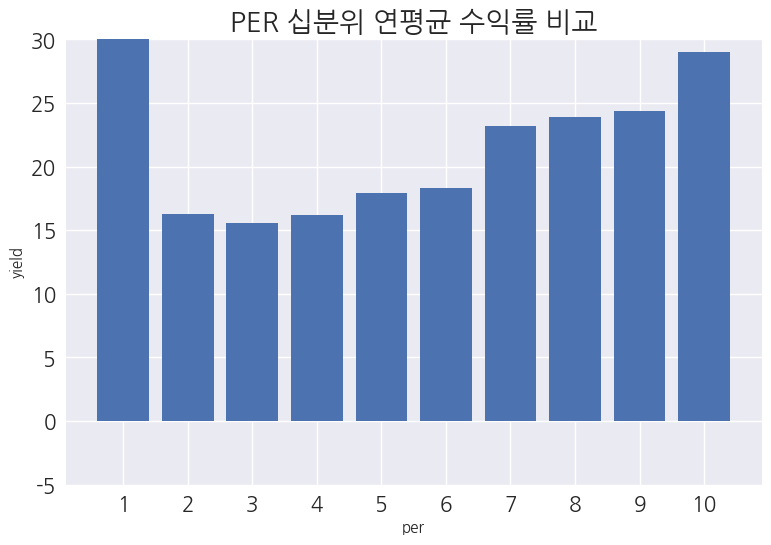

[18.03597353 17.35013919 23.09012837 17.37374398 17.61229876 17.89338127
 24.57410883 24.22698211 23.31935402 34.76207869]


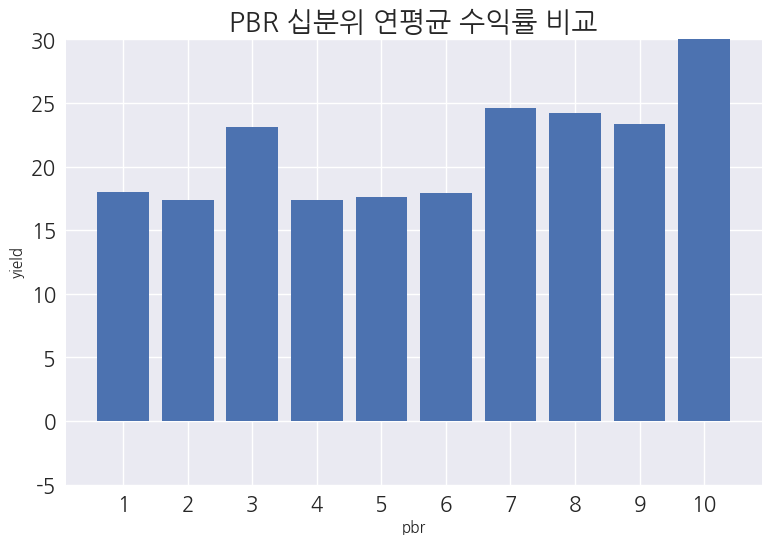

[21.84517035 15.27289464 15.04449545 15.63731434 18.31273467 18.67343577
 23.99236382 24.01927562 22.66196424 27.1956505 ]


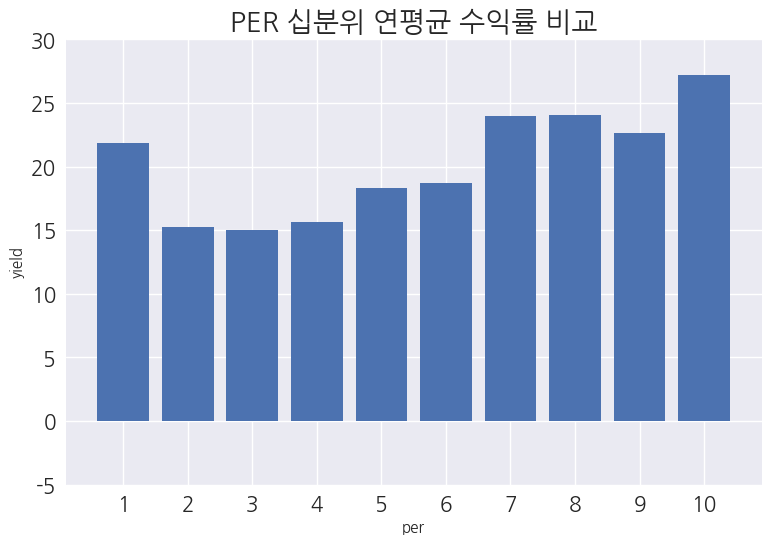

[16.28432275 15.92470595 22.46934919 18.06299279 16.58684181 19.8478636
 19.69915209 24.35773895 23.96127815 30.8997164 ]


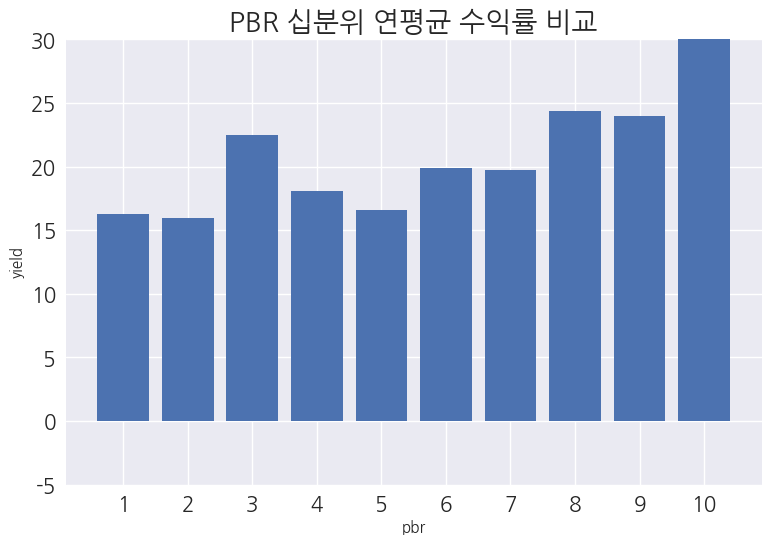

[14.88974882 13.01731224 11.70845208 12.0093376  12.3204422  10.36575668
 15.58838214 15.49344106 12.60384812 13.01390265]


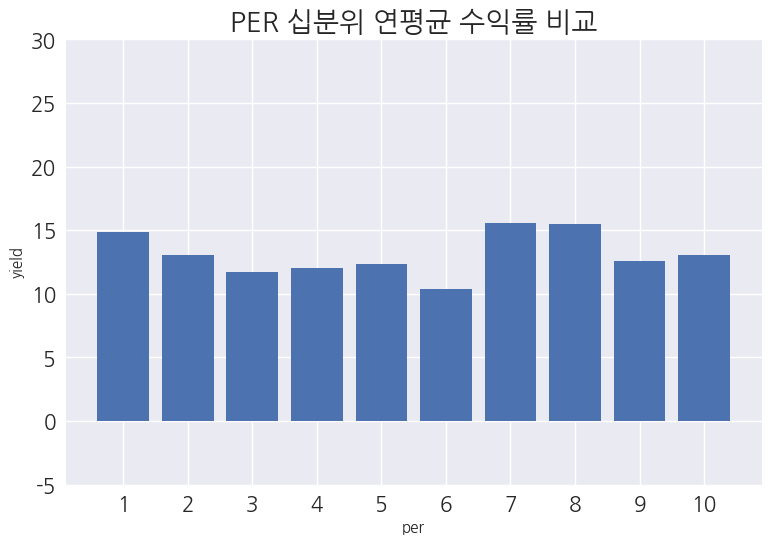

[17.53561641 13.51443095 11.57350319  7.16209909 14.09438965 11.05331964
 10.35747264 12.00128    12.61133044 17.62787401]


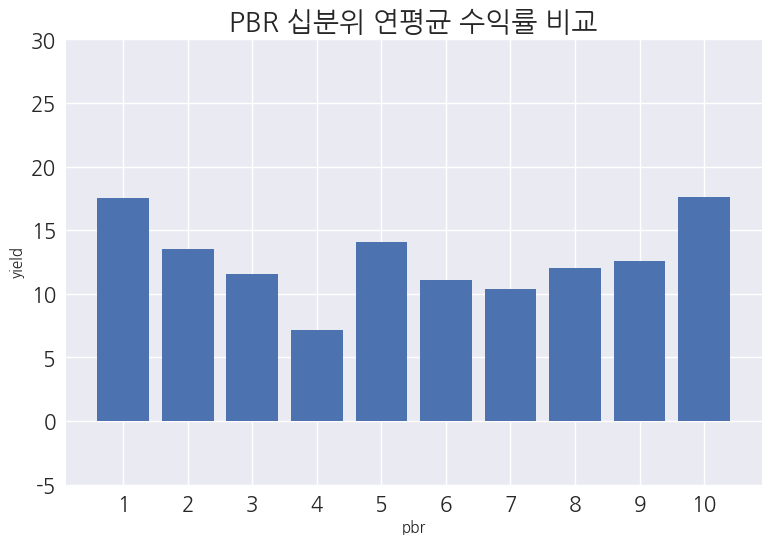

In [42]:
ten_group_plot(amean)
ten_group_plot(amean_refined)
ten_group_plot(amean_refined_harsh)